In [ ]:
# Exploration on the scRNA-seq networks

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean, mode
import powerlaw
import os

from CoSiNe.community_detection.louvain_signed import *

In [2]:
# Load all necessary functions

def create_graph_from_file(file_path: str, directory: str, alpha: float, filename: str, n_lines: int = None, cdi_threshold: float = 5.0, eei_threshold: float = 1.0, apply_pareto: bool = True):
    """
    Creates a graph from a file and applies the Pareto principle to identify top nodes.

    Parameters:
    - file_path (str): Path to the file.
    - directory (str): Directory where plots will be saved.
    - alpha (float): Alpha value for the LouvainSigned algorithm.
    - filename (str): The name of the file where the plot will be saved.
    - n_lines (int, optional): Number of lines to read. If None, reads the whole file.
    - cdi_threshold (float, optional): Threshold to be used if filename contains "CDI". Default is 5.0.
    - eei_threshold (float, optional): Threshold to be used if filename contains "EEI". Default is 1.0.
    - apply_pareto (bool, optional): Whether to apply the Pareto principle to identify top nodes.

    Returns:
    - G (networkx.Graph): The created subgraph containing top nodes.
    - Dict: Statistical measures of the weights (median, mean, mode, max, min).
    - List: Top 20% nodes contributing to 80% of the connectivity.
    """
    G, weights, node_degrees = read_file_and_create_graph(file_path, n_lines, cdi_threshold, eei_threshold)
    
    if G is None:
        return None, {}, []

    weight_stats = calculate_weight_statistics(weights)
    plot_weight_distribution(weights, weight_stats["median"], weight_stats["mean"], weight_stats["mode"], weight_stats["max"], weight_stats["min"], directory, filename, alpha)
    plt.close()

    # Plot degree distribution
    plot_degree_distribution(G, directory, filename)
    plt.close()
    
    if apply_pareto:
        sorted_nodes_by_degree, total_degree = calculate_degree_distribution(node_degrees)
        top_nodes = apply_pareto_principle(sorted_nodes_by_degree, total_degree)

        # Create subgraph with top nodes
        subgraph = G.subgraph(top_nodes).copy()
        print(f"Graph: Nodes={subgraph.number_of_nodes()}, Edges={subgraph.number_of_edges()}")
        
        return subgraph, weight_stats, top_nodes
    else:
        print(f"Graph: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")
        return G, weight_stats, []


def read_file_and_create_graph(file_path: str, n_lines: int = None, cdi_threshold: float = 5.0, eei_threshold: float = 1.0):
    """
    Reads a file, creates a graph, and tracks weights and node degrees.
    """
    G = nx.Graph()
    weights = []
    node_degrees = {}
    threshold = cdi_threshold if "CDI" in file_path else eei_threshold if "EEI" in file_path else 0.0

    try:
        with open(file_path, 'r') as f:
            if n_lines is not None:
                n_lines = int(n_lines)  

            for i, line in enumerate(f):
                if i == 0 or (n_lines is not None and i > n_lines):
                    continue  # Skip header or excess lines
                columns = line.strip().split()
                if len(columns) < 5:
                    continue
                node1, node2, weight = columns[2], columns[3], float(columns[4])
                weights.append(weight)
                if weight >= threshold:
                    G.add_edge(node1, node2, weight=weight)
                    node_degrees[node1] = node_degrees.get(node1, 0) + 1
                    node_degrees[node2] = node_degrees.get(node2, 0) + 1

    except FileNotFoundError:
        print(f"Error: File {file_path} could not be opened.")
        return None, [], {}

    return G, weights, node_degrees


def calculate_weight_statistics(weights: list):
    """
    Calculates statistical measures of the weights.
    """
    try:
        mode_weight = mode(weights)
    except:
        mode_weight = "No unique mode"

    median_weight = median(weights) if weights else 0
    mean_weight = mean(weights) if weights else 0
    max_weight = max(weights) if weights else 0
    min_weight = min(weights) if weights else 0

    return {
        "median": median_weight,
        "mean": mean_weight,
        "mode": mode_weight,
        "max": max_weight,
        "min": min_weight
    }


def plot_weight_distribution(weights, median_weight, mean_weight, mode_weight, max_weight, min_weight, directory, filename, alpha):
    """
    Plots the distribution of weights.

    Parameters:
    - weights (list): List of weights to be plotted.
    - median_weight (float): The median value of weights.
    - mean_weight (float): The mean value of weights.
    - mode_weight (float or str): The mode value of weights, or a string indicating no unique mode.
    - max_weight (float): The maximum weight value.
    - min_weight (float): The minimum weight value.
    - output_dir (str): The directory where the plot will be saved.
    - filename (str): The name of the file where the plot will be saved.
    """

    if not weights:
        print("No data to plot.")
        return

def annotate_stat(stat, name, color, y_pos):
    plt.axvline(x=stat, color=color, linestyle='dashed', linewidth=1)
    plt.annotate(f'{name}: {stat:.2f}', xy=(stat, 0), xytext=(stat, plt.gca().get_ylim()[1] * y_pos), arrowprops=dict(facecolor='black', arrowstyle='->'), color=color)

    plt.hist(weights, bins=30, edgecolor='k', alpha=0.1)

    annotate_stat(median_weight, 'Median', 'red', 0.6)
    annotate_stat(mean_weight, 'Mean', 'green', 0.5)
    annotate_stat(max_weight, 'Max', 'magenta', 0.3)
    annotate_stat(min_weight, 'Min', 'cyan', 0.2)
    
    if mode_weight != "No unique mode":
        annotate_stat(mode_weight, 'Mode', 'blue', 0.4)

    plt.title("Distribution of Weights")
    plt.xlabel("Weight")
    plt.ylabel("Frequency")

    # Save the plot to a file
    filepath = f"{directory}/{filename}_{alpha}_WeightDist.png"
    plt.savefig(filepath)
    plt.clf()  # Clear the plot
    print(f"Plot saved to {filepath}\n")


def plot_degree_distribution(graph: nx.Graph, directory: str, filename: str):
    """
    Plots the degree distribution and fits a power-law distribution.
    """
    degrees = [degree for _, degree in graph.degree()]
    degree_counts = np.bincount(degrees)
    degree_values = np.nonzero(degree_counts)[0]
    degree_probabilities = degree_counts[degree_values] / sum(degree_counts)

    plt.figure(figsize=(10, 6))
    plt.loglog(degree_values, degree_probabilities, 'bo', label='Degree Distribution')

    # Fit to a power-law distribution using the powerlaw package
    fit = powerlaw.Fit(degrees, discrete=True)
    alpha = fit.power_law.alpha
    xmin = fit.power_law.xmin

    # Plot the power-law fit
    fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power-law fit: alpha={alpha:.2f}, xmin={xmin:.2f}')
    
    plt.title('Degree Distribution with Power-law Fit')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.savefig(f"{directory}/{filename}_degree_distribution.png")
    plt.show()

def calculate_degree_distribution(node_degrees: dict):
    """
    Calculates the degree distribution of nodes.
    """
    sorted_nodes_by_degree = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)
    total_degree = sum(node_degrees.values())
    return sorted_nodes_by_degree, total_degree

def apply_pareto_principle(sorted_nodes_by_degree: list, total_degree: int):
    """
    Applies the Pareto principle to identify top nodes.
    """
    cumulative_degree = 0
    top_nodes = []

    for node, degree in sorted_nodes_by_degree:
        cumulative_degree += degree
        top_nodes.append(node)
        if cumulative_degree / total_degree >= 0.8:
            break

    return top_nodes

In [3]:
import networkx as nx

def load_data_manually(edge_file, community_file):
    G = nx.Graph()

    # 1) Read edges:
    with open(edge_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            node1, node2 = line.split()
            G.add_edge(node1, node2)

    # 2) Read community info:
    community_dict = {}
    with open(community_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            node, comm = line.split()
            community_dict[node] = int(comm) if comm.isdigit() else comm

    # 3) Attach community info as an attribute
    #    Only set attributes if the node is in the graph
    for node, comm in community_dict.items():
        if node in G:
            G.nodes[node]['community'] = comm

    return G

In [5]:
edge_file = "../data/PBMC/pbmc_cdi_partition_lfr_20/network.dat"
community_file = "../data/PBMC/pbmc_cdi_partition_lfr_20/community.dat"
G = load_data_manually(edge_file, community_file)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 5408
Number of edges: 903722


In [6]:
communities = nx.get_node_attributes(G, 'community')
# communities is a dict: { 'nodeA': 1, 'nodeB': 1, 'nodeC': 2, ... }

alpha: 1.0, resolution: 1.0
Final Modularity: 0.6680729245484429
Positive Modularity (Q+): 0.6680729245484429
Negative Modularity (Q-): 0.6680729245484429
alpha: 1.0, resolution: 1.0
Final Modularity: 0.6696638563345857
Positive Modularity (Q+): 0.6696638563345857
Negative Modularity (Q-): 0.6696638563345857
alpha: 1.0, resolution: 1.0
Final Modularity: 0.6693197816877556
Positive Modularity (Q+): 0.6693197816877556
Negative Modularity (Q-): 0.6693197816877556
alpha: 1.0, resolution: 1.0
Final Modularity: 0.6689536738297331
Positive Modularity (Q+): 0.6689536738297331
Negative Modularity (Q-): 0.6689536738297331
alpha: 1.0, resolution: 1.0
Final Modularity: 0.6696284408110829
Positive Modularity (Q+): 0.6696284408110829
Negative Modularity (Q-): 0.6696284408110829
alpha: 1.0, resolution: 1.0
Final Modularity: 0.669635728763762
Positive Modularity (Q+): 0.669635728763762
Negative Modularity (Q-): 0.669635728763762
alpha: 1.0, resolution: 1.0
Final Modularity: 0.6694913732214038
Positive

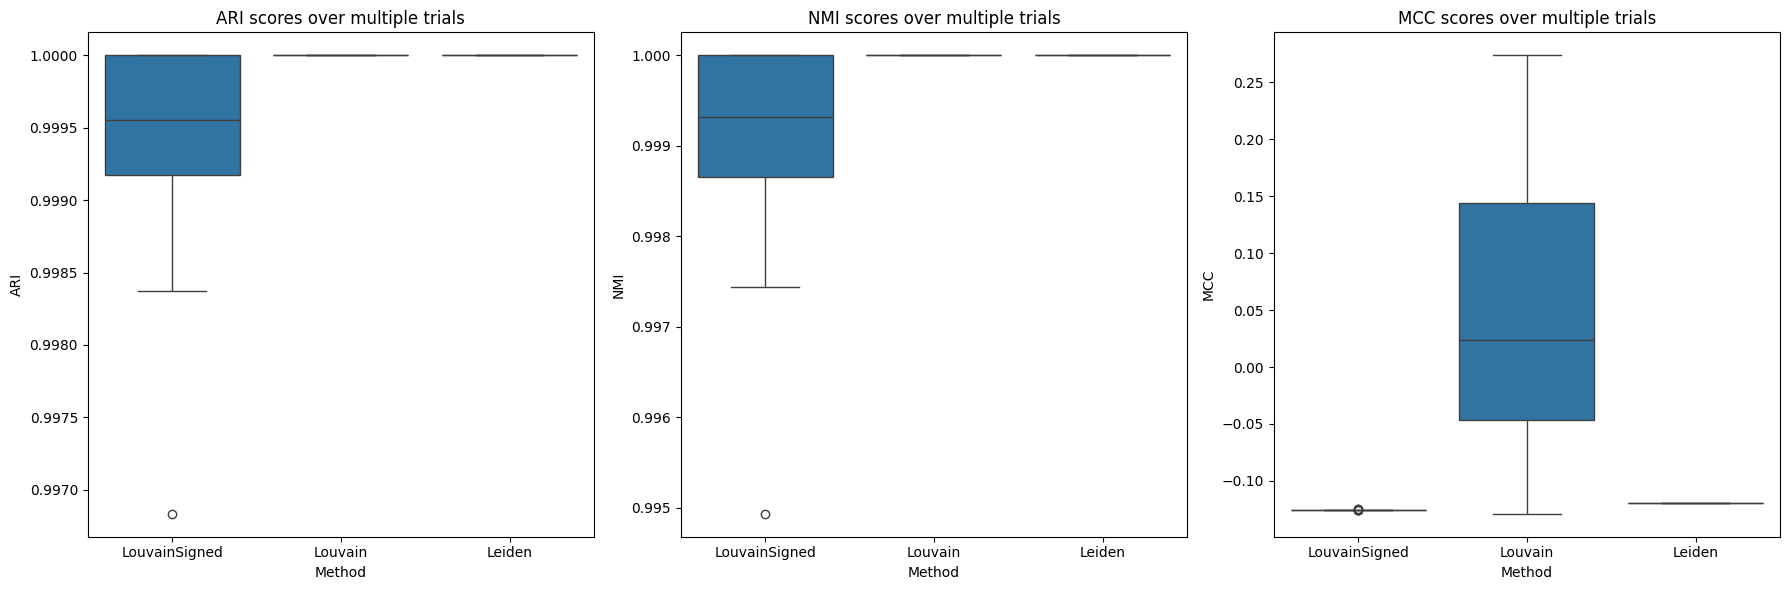

In [14]:
import networkx as nx
import igraph as ig
import leidenalg as la
import community as community_louvain  # python-louvain
# If you have a custom module or class for LouvainSigned, import it too
# from your_signed_louvain_module import LouvainSigned

from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Number of repeated trials (e.g., different random initializations)
num_trials = 20

def compute_mcc(true_labels, predicted_labels):
    return matthews_corrcoef(true_labels, predicted_labels)

def evaluate_communities(G, num_trials=1):
    # Prepare a consistent node list
    node_list = list(G.nodes())

    # Ground truth labels in the same order as node_list
    # (Assumes 'community' attribute is set for each node)
    true_labels = [G.nodes[n]['community'] for n in node_list]

    results = []

    for _ in range(num_trials):
        # --- 1) LouvainSigned (hypothetical custom module) ---
        # The usage here depends on your actual LouvainSigned API.
        # partition = LouvainSigned(G, G, 0.6).best_partition() 
        # If it returns a dict {node: community}, do the same indexing:
        # louvain_signed_labels = [partition[n] for n in node_list]
        #
        # For now, let's comment it out or illustrate generically:
        
        partition_signed = LouvainSigned(G, G).best_partition()
        louvain_signed_labels = [partition_signed[n] for n in node_list]
        results.append({
            'Method': 'LouvainSigned',
            'ARI': metrics.adjusted_rand_score(true_labels, louvain_signed_labels),
            'NMI': metrics.normalized_mutual_info_score(true_labels, louvain_signed_labels),
            'MCC': compute_mcc(true_labels, louvain_signed_labels)
        })
        
        # --- 2) Louvain (python-louvain) ---
        # partition is a dict: {node: community_id}
        partition = community_louvain.best_partition(G)
        louvain_labels = [partition[n] for n in node_list]

        results.append({
            'Method': 'Louvain',
            'ARI': metrics.adjusted_rand_score(true_labels, louvain_labels),
            'NMI': metrics.normalized_mutual_info_score(true_labels, louvain_labels),
            'MCC': compute_mcc(true_labels, louvain_labels)
        })

        # --- 3) Leiden ---
        # Convert NetworkX graph -> igraph
        # Use a consistent node order with nodelist=node_list
        adj_matrix = nx.to_numpy_array(G, nodelist=node_list)
        G_ig = ig.Graph.Adjacency((adj_matrix > 0).tolist())

        # Leiden with ModularityVertexPartition (or another partition type)
        partition_leiden = la.find_partition(G_ig, la.ModularityVertexPartition)
        leiden_labels = partition_leiden.membership  # list of community IDs in iGraph node order
        # iGraph nodes now match the indexing of node_list

        results.append({
            'Method': 'Leiden',
            'ARI': metrics.adjusted_rand_score(true_labels, leiden_labels),
            'NMI': metrics.normalized_mutual_info_score(true_labels, leiden_labels),
            'MCC': compute_mcc(true_labels, leiden_labels)
        })

    return pd.DataFrame(results)

def main():
    # 1) Load your graph
    edge_file = "../data/PBMC/pbmc_cdi_partition_lfr_20/network.dat"
    community_file = "../data/PBMC/pbmc_cdi_partition_lfr_20/community.dat"
    G = load_data_manually(edge_file, community_file)

    # 2) Evaluate
    results = evaluate_communities(G, num_trials=num_trials)

    # 3) Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.boxplot(x='Method', y='ARI', data=results, ax=axes[0])
    axes[0].set_title("ARI scores over multiple trials")

    sns.boxplot(x='Method', y='NMI', data=results, ax=axes[1])
    axes[1].set_title("NMI scores over multiple trials")

    sns.boxplot(x='Method', y='MCC', data=results, ax=axes[2])
    axes[2].set_title("MCC scores over multiple trials")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Calculating best minimal value for power law fit


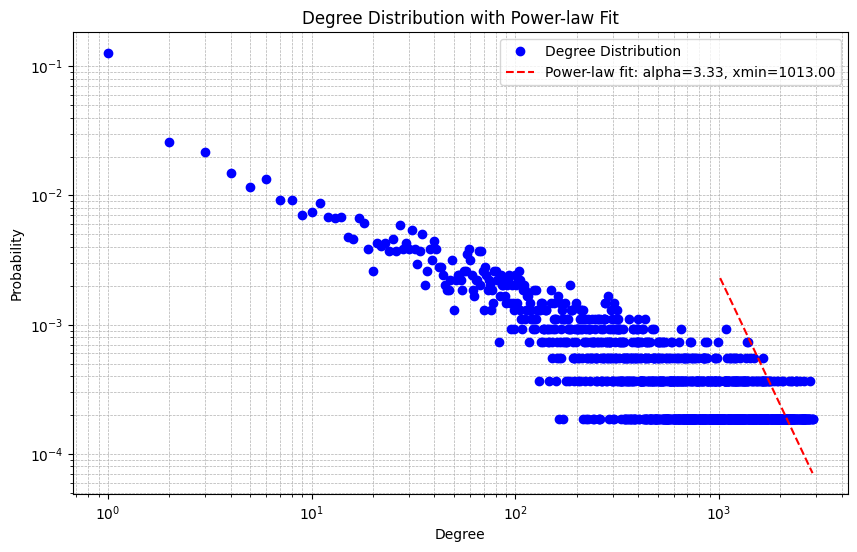

Graph: Nodes=1328, Edges=594515
Calculating best minimal value for power law fit


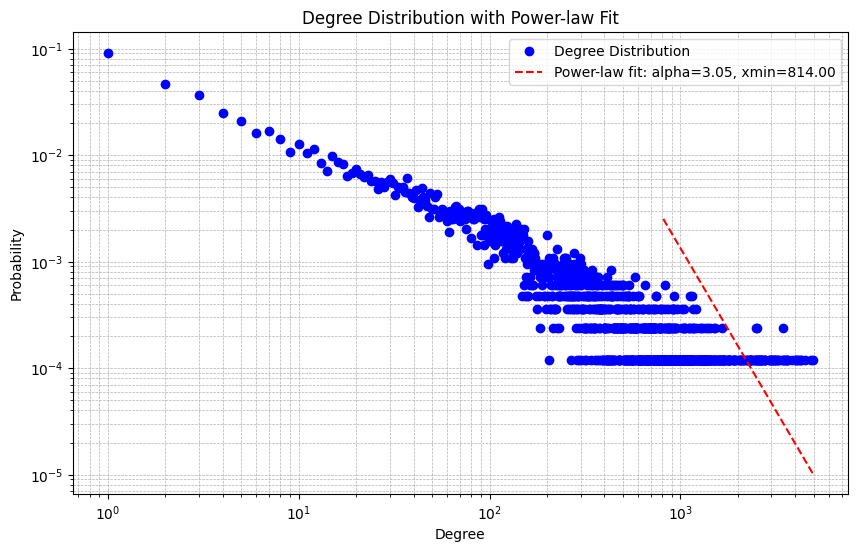

Graph: Nodes=1814, Edges=462445


In [ ]:
sample_name = "PBMC_LFR"

# Load the graph from the file
g_pos_path = "../data/PBMC/pbmc_cdi_parititon_lfr_20/
#g_neg_path = "../data/PBMC/PBMC_2_EEI_score_data_thre1.0.txt"

# output path
plots_dir = "data_exploration_PBMC"

# alpha value
alpha_value = 0.6

G_positive, stats_positive, top_nodes_positive = create_graph_from_file(
    g_pos_path, plots_dir, alpha_value, filename=f"{sample_name}_pos", apply_pareto=True
)
G_negative, stats_negative, top_nodes_negative = create_graph_from_file(
    g_neg_path, plots_dir, alpha_value, filename=f"{sample_name}_neg", apply_pareto=True
)


In [51]:
# Function to compute graph statistics
def compute_graph_stats(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = dict(G.degree())
    avg_degree = np.mean(list(degrees.values())) if num_nodes > 0 else 0
    degree_distribution = np.array(list(degrees.values())) if num_nodes > 0 else np.array([])
    density = nx.density(G)

    # Component Analysis
    if nx.is_directed(G):
        largest_cc = max(nx.strongly_connected_components(G), key=len) if num_nodes > 0 else set()
    else:
        largest_cc = max(nx.connected_components(G), key=len) if num_nodes > 0 else set()

    clustering_coeffs = nx.clustering(G) if num_nodes > 0 else {}
    avg_clustering = np.mean(list(clustering_coeffs.values())) if num_nodes > 0 else 0

    # Shortest Path Length
    if num_nodes > 1 and nx.is_connected(G.to_undirected()):
        avg_shortest_path = nx.average_shortest_path_length(G.to_undirected())
    else:
        avg_shortest_path = None

    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "avg_degree": avg_degree,
        "max_degree": max(degree_distribution) if num_nodes > 0 else 0,
        "min_degree": min(degree_distribution) if num_nodes > 0 else 0,
        "density": density,
        "largest_cc_size": len(largest_cc),
        "avg_clustering": avg_clustering,
        "avg_shortest_path": avg_shortest_path,
        "degree_distribution": degree_distribution
    }

# Compute Statistics
stats_pos = compute_graph_stats(G_positive)
stats_neg = compute_graph_stats(G_negative)


In [52]:
# Print Basic Statistics
def print_stats(stats, label):
    print(f"\n=== {label} Network ===")
    print(f"Number of nodes: {stats['num_nodes']}")
    print(f"Number of edges: {stats['num_edges']}")
    print(f"Average degree: {stats['avg_degree']:.2f}")
    print(f"Max degree: {stats['max_degree']}")
    print(f"Min degree: {stats['min_degree']}")
    print(f"Network density: {stats['density']:.6f}")
    print(f"Largest connected component size: {stats['largest_cc_size']}")
    print(f"Average clustering coefficient: {stats['avg_clustering']:.4f}")
    if stats['avg_shortest_path']:
        print(f"Average shortest path length: {stats['avg_shortest_path']:.4f}")
    else:
        print("Graph is not fully connected. Shortest path length undefined.")

print_stats(stats_pos, "Positive")
print_stats(stats_neg, "Negative")



=== Positive Network ===
Number of nodes: 1328
Number of edges: 594515
Average degree: 895.35
Max degree: 1320
Min degree: 2
Network density: 0.674720
Largest connected component size: 1323
Average clustering coefficient: 0.8552
Graph is not fully connected. Shortest path length undefined.

=== Negative Network ===
Number of nodes: 1814
Number of edges: 462445
Average degree: 509.86
Max degree: 1106
Min degree: 86
Network density: 0.281226
Largest connected component size: 1814
Average clustering coefficient: 0.0165
Average shortest path length: 1.8633


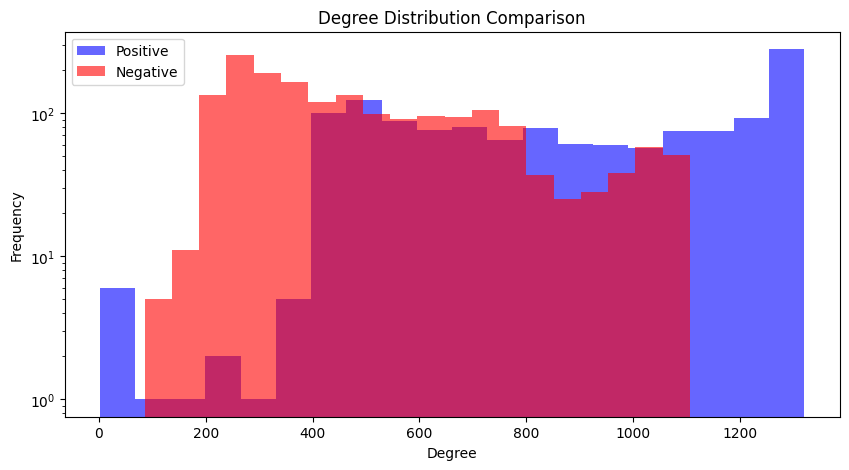

In [55]:
# Degree Distribution Plot
plt.figure(figsize=(10, 5))
plt.hist(stats_pos["degree_distribution"], bins=20, alpha=0.6, color='blue', label="Positive")
plt.hist(stats_neg["degree_distribution"], bins=20, alpha=0.6, color='red', label="Negative")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Degree Distribution Comparison")
plt.legend()
plt.savefig(os.path.join(plots_dir, f"{sample_name}_degree_distribution.png"))
plt.show()

In [56]:
# Centrality Measures (Top 5 Nodes)
def get_top_nodes(G, metric_func):
    centrality = metric_func(G)
    return sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]

top_degree_pos = get_top_nodes(G_positive, nx.degree_centrality)
top_degree_neg = get_top_nodes(G_negative, nx.degree_centrality)
top_betweenness_pos = get_top_nodes(G_positive, nx.betweenness_centrality)
top_betweenness_neg = get_top_nodes(G_negative, nx.betweenness_centrality)
top_closeness_pos = get_top_nodes(G_positive, nx.closeness_centrality)
top_closeness_neg = get_top_nodes(G_negative, nx.closeness_centrality)

print("\n=== Top Nodes by Degree Centrality ===")
print("Positive:", top_degree_pos)
print("Negative:", top_degree_neg)

print("\n=== Top Nodes by Betweenness Centrality ===")
print("Positive:", top_betweenness_pos)
print("Negative:", top_betweenness_neg)

print("\n=== Top Nodes by Closeness Centrality ===")
print("Positive:", top_closeness_pos)
print("Negative:", top_closeness_neg)



=== Top Nodes by Degree Centrality ===
Positive: [('FGD2', 0.9947249434815373), ('IFI30', 0.9947249434815373), ('SKAP2', 0.9947249434815373), ('CTBP2', 0.9939713639788997), ('NOTCH2', 0.9939713639788997)]
Negative: [('LEF1', 0.61003861003861), ('IL7R', 0.6023166023166023), ('CAMK4', 0.6023166023166023), ('TCF7', 0.6012134583563156), ('TRABD2A', 0.5984555984555985)]

=== Top Nodes by Betweenness Centrality ===
Positive: [('LYN', 0.0007885418311479003), ('FGD2', 0.0007866085942487898), ('SYK', 0.0007835205335167788), ('TRIO', 0.0007747533749803237), ('HDAC9', 0.0007716744367480403)]
Negative: [('CCR7', 0.004249870539388397), ('SERINC5', 0.0032915802661660433), ('LEF1', 0.003059663627472296), ('BACH2', 0.002941247502265973), ('PYHIN1', 0.0027234933568608794)]

=== Top Nodes by Closeness Centrality ===
Positive: [('FGD2', 0.9947272201567718), ('IFI30', 0.9947272201567718), ('SKAP2', 0.9947272201567718), ('CTBP2', 0.9939764826321252), ('NOTCH2', 0.9939764826321252)]
Negative: [('LEF1', 0.7

In [57]:
# Graph Visualization (Optional, only for small graphs)
if stats_pos["num_nodes"] < 500:
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_positive, seed=42)
    nx.draw(G_positive, pos, node_size=50, edge_color="gray", alpha=0.7)
    plt.title("Positive Graph Visualization")
    plt.savefig(os.path.join(plots_dir, f"{sample_name}_positive_graph.png"))
    plt.show()

if stats_neg["num_nodes"] < 500:
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_negative, seed=42)
    nx.draw(G_negative, pos, node_size=50, edge_color="gray", alpha=0.7)
    plt.title("Negative Graph Visualization")
    plt.savefig(os.path.join(plots_dir, f"{sample_name}_negative_graph.png"))
    plt.show()

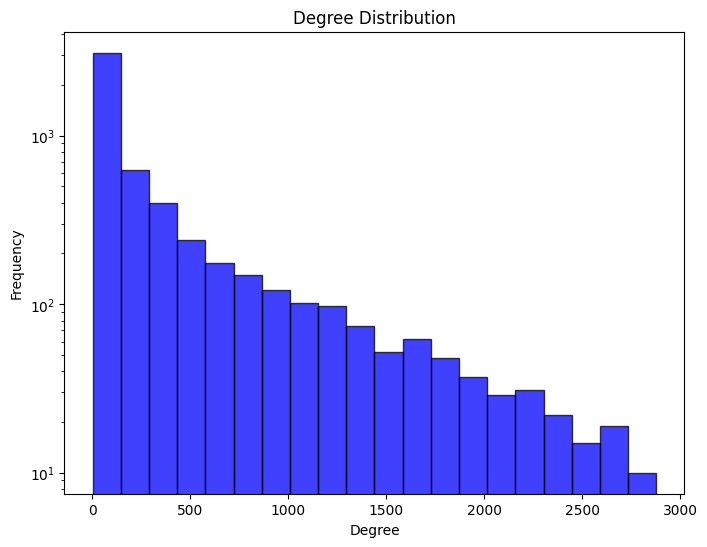

In [14]:
# Degree Distribution Plot
plt.figure(figsize=(8, 6))
plt.hist(degree_distribution, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.yscale("log")
plt.show()

In [ ]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_degree_nodes_named = [(G.nodes[node][‘name’], centrality) for node, centrality in top_degree_nodes]

print("Top 5 nodes by degree centrality:", top_degree_nodes_named)

Top 5 nodes by degree centrality: [('2757', 0.5324579249121509), ('12537', 0.5324579249121509), ('7027', 0.5296837432957278), ('12208', 0.5237654891806917), ('14727', 0.5182171259478454)]


In [16]:
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness_nodes_named = [(G.nodes[node][‘name’], centrality) for node, centrality in top_betweenness_nodes]

print("Top 5 nodes by betweenness centrality:", top_betweenness_nodes_named)

Top 5 nodes by betweenness centrality: [('1696', 0.022895720938525946), ('8514', 0.021307715945207775), ('230', 0.017739397566842015), ('12537', 0.017416263341229855), ('7002', 0.013879561406504622)]


In [17]:
# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)
top_closeness_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness_nodes_named = [(G.nodes[node][‘name’], centrality) for node, centrality in top_closeness_nodes]

print("Top 5 nodes by closeness centrality:", top_closeness_nodes_named)

SyntaxError: invalid character '‘' (U+2018) (29296795.py, line 4)

In [ ]:
# Graph Visualization (Optional, only for small graphs)
if num_nodes < 500:
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=50, edge_color="gray", alpha=0.7)
    plt.title("Graph Visualization")
    plt.show()